# Statistical Modeling
Until now we learned various ways of organizing, transforming and visualizing data. What we have (except the last 10 minutes of last week) not attempted so far is describing the structure that underlies our data. What we would like to do is to look beyond the samples of the dataset and make statements about the process that generated the data. This would allow us
to generalize to unseen samples that are generated by the same process.

Modeling is exactly the attempt of to describe data by some structure (the model) and some parameters. The choice of the model is usually something that we explicitly have to make, while the parameters are then fitted to the data algorithmically. There a two main branches of data driven modeling: 

### Machine Learning
* split your data into training and test sets
* fit on the training set
* evaluate generalization performance on the test set

### Statistical Modeling
* fit on all data
* check assumptions
* interpret parameters

While on the application side, machine learning is more popular, statistical modeling is better suited for interpretation of scientific experiments, as the parameters usually have an easier interpretation.

![](figures/sample.png)

# Linear models

Lots of different statistical models are implemented in the `statsmodels` package. While one could do a whole course on all the different models, we only have time to focus on the most simple one: *linear regression*. The good thing is that most of the models in `statsmodels` follow the same interface, so you should be able transfer you knowledge about linear regression to more complex models.

Further, [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model) can even capture basically all statistical tendencies:
![](figures/linear_models_alternate_view.png)


The general form of a (pure) linear regression model is 

\begin{equation}
\mathbf{y} = \mathbf{X}\mathbf{\beta} + \mathbf{\epsilon}
\end{equation}

with $\mathbf{y}$ being the endogenous or predicted variable, $\mathbf{X}$ is the design matrix containing the exogenous or predictor variables, $\beta$ are the parameters and $\epsilon$ are the errors. The errors are assumed to be normally distributed with a mean of zero and a constant variance.


\begin{equation}
\epsilon \sim \mathcal{N}(0, \sigma^2)
\end{equation}

That means that given an $x$ we can say as much as that the $y$ value will be determined by a normal distribution centered at the predicted $\hat y$.

# Simple linear regression

In the case where we only have a single predictor $\beta$ only contains the intercept $a$ and the slope $b$. We can write $\beta = \begin{pmatrix} a \\ b\end{pmatrix}$
 
Given this the original equation simplifies to

\begin{equation}
y_i = a + x_i \cdot b + \epsilon_i
\end{equation}


Let's visualize how this would look like in terms the predicted probability density.

In [1]:
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from plotnine import *
from scipy import stats
sys.path.append("..")
from utils import count_down



class SimpleLinearModel:
    def __init__(self, a, b, σ=1):
        self.a = a
        self.b = b
        self.σ = σ

    def predict(self, x, vmin=0, vmax=5):
        y_hat = self.a + x * self.b
        distribution = stats.norm(loc=y_hat, scale=self.σ)
        y_range = np.linspace(vmin, vmax, 100)
        return distribution.pdf(y_range)


def plot_prediction(predictions, vmin, vmax):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(predictions, ax=ax, cmap="viridis", cbar_kws=dict(label="density"))
    ax.invert_yaxis()
    #ax.set_yscale('symlog')
    ax.set_xticklabels(
        [f"{t:.1f}" for t in np.linspace(vmin, vmax, len(ax.get_xticklabels()))],
        rotation="vertical",
    )
    ax.set_yticklabels(
        [f"{t:.1f}" for t in np.linspace(vmin, vmax, len(ax.get_yticklabels()))],
        rotation="horizontal",
    )
    ax.set(xlabel="x", ylabel="y")

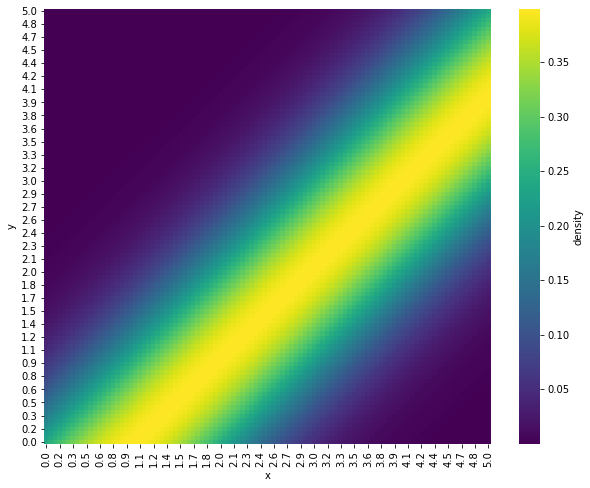

In [2]:
model = SimpleLinearModel(a=-1, b=1, σ=1)
x_range = np.linspace(0, 5, 100)
predictions = []
for x in x_range:
    prediction = model.predict(x)
    predictions.append(prediction)

predictions = np.array(predictions).T

plot_prediction(predictions, 0, 5)

If we would again allow for GLMs and change to the logit-scale, this will change the interplay like this: 

![alt](figures/linear_models_parameters.png)

But with the knowledge that we could to more in mind, let's stick with the simple case of the linar regression for this lecture.

We see that the simple linear model predicts data as a normal distribution of fixed variance, whose mean moves along a straight line.

We will now generate some random data based on that model and see if we can recover our original parameters using linear regression.

In [166]:
def generate_data(intercept=1, slope=1, n_samples=100, scale=1):
    np.random.seed(0)
    x = np.linspace(0, 10, n_samples)
    noise = np.random.normal(scale=scale, size=n_samples)
    y = intercept + x * slope + noise
    data = pd.DataFrame({"x": x, "y": y})
    return data, x


intercept = 5
slope = 2
data, x = generate_data(intercept, slope)
data.head()

,x,y
0,0.00000,6.764052
1,0.10101,5.602177
2,0.20202,6.382778
3,0.30303,7.846954
4,0.40404,7.675639


We can verify that the relationship between x and y indeed looks very linear.

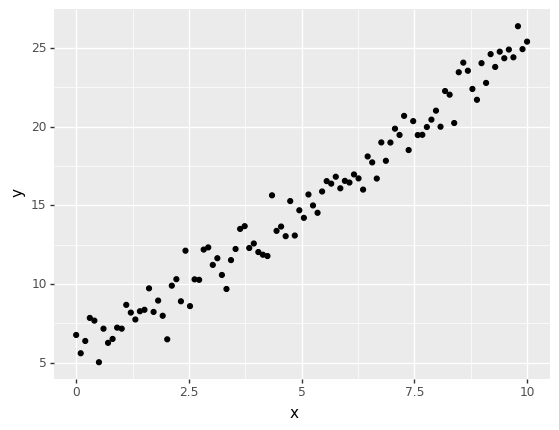

<ggplot: (8745687097976)>

In [167]:
(ggplot(data, aes(x="x", y="y")) + geom_point())

## The manual way

![](figures/residuals.png)

Now we want to find the parameters that describe the line that minimize some error function given the points. It turns out that given our assumption of normally distributed errors, the error measure to use is the square of the residuals. Morevorer, it turns out that the parameters with a minimal error can be found with the Moore-Penrose pseudoinverse. The name comes from the fact that the pseudoinverse matrix is the closest we can find to a real inverse that solves the given system of equations. This topic is given proper treatment in the Neuroinformatics lecture. The takeaway for now is just that simple linear models have a closed form solution and therefore do not require numerical optimization.

For some better understanding we will now produce the designmatrix and the pseudoinverse manually.

In [168]:
designmatrix = np.zeros((y.size, 2))
designmatrix[:, 0] = 1
designmatrix[:, 1] = x
designmatrix[:10]

array([[1.        , 0.        ],
       [1.        , 0.1010101 ],
       [1.        , 0.2020202 ],
       [1.        , 0.3030303 ],
       [1.        , 0.4040404 ],
       [1.        , 0.50505051],
       [1.        , 0.60606061],
       [1.        , 0.70707071],
       [1.        , 0.80808081],
       [1.        , 0.90909091]])

The pseudoinverse of designmatrix $X$ is defined by

$$ X^\dagger = (X^T X)^{-1}X^T$$

In [169]:
#wondering why np.linalg.inv?
#   "... all of the Numpy functions have been subsumed into the scipy namespace so that all of those functions are available without additionally importing Numpy."
#   https://stackoverflow.com/questions/6200910/relationship-between-scipy-and-numpy

In [170]:
def pseudoinverse(designmatrix):
    return np.linalg.inv(designmatrix.T @ designmatrix) @ designmatrix.T


pinv = pseudoinverse(designmatrix)
pinv[:, :10]

array([[ 0.03940594,  0.03881188,  0.03821782,  0.03762376,  0.0370297 ,
         0.03643564,  0.03584158,  0.03524752,  0.03465347,  0.03405941],
       [-0.00588119, -0.00576238, -0.00564356, -0.00552475, -0.00540594,
        -0.00528713, -0.00516832, -0.0050495 , -0.00493069, -0.00481188]])

In [171]:
pinv.shape

(2, 100)

In [172]:
β = pinv @ y
β

array([5.20847145, 1.97026731])

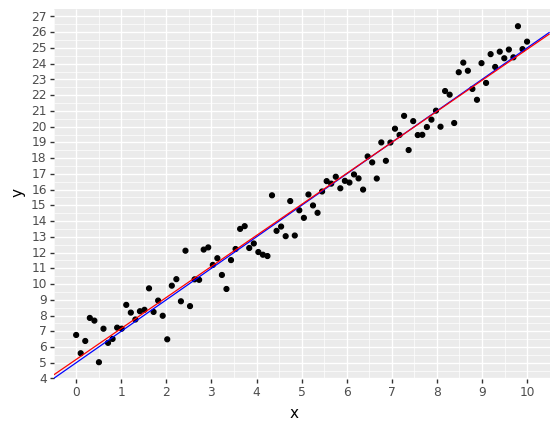

<ggplot: (-9223363291168055285)>

In [173]:
(
    ggplot(data, aes(x="x", y="y"))
    + geom_point()
    + geom_abline(intercept=intercept, slope=slope, color="blue")
    + geom_abline(intercept=β[0], slope=β[1], color="red")
    + scale_x_continuous(breaks=range(11))
    + scale_y_continuous(breaks=range(31))
)

## Half automated using `patsy`
That worked pretty well, the original parameters were recovered almost exactly. However, we still had to do a lot of work ourself. Building the designmatrix and calculting the pseudoinverse are things that you should not have to think about when doing statistical modeling. Let's look at the tools to automate them.

The first tool is `patsy` that lets us describe statistical models in terms of R-style formulas and builds design matrices out of them.

In [174]:
import patsy

A `patsy` formula always looks like `endog ∼ exog`. On the left of the $\sim$ is the variable you want to predict and on the right are a combination of predictors. Inside of a `patsy` formula you can refer to

1. keys from the dataframe
1. variables from the global namespace
1. some special `patsy` functions
1. any valid Python function

By default, `patsy` will always include an intercept. The function `dmatrices` always gives us two designmatrices: one for the predicted and one for the predictor variables.
The returned `DesignMatrix` objects are just thin wrappers around `numpy` arrays, i.e. they can be used exactly as arrays and just have a nicer string representation.


In [177]:
y_dm, X_dm = patsy.dmatrices("y ~ x", data)
y_dm

DesignMatrix with shape (100, 1)
         y
   6.76405
   5.60218
   6.38278
   7.84695
   7.67564
   5.03282
   7.16221
   6.26278
   6.51294
   7.22878
   7.16425
   8.67650
   8.18528
   7.74794
   8.27215
   8.36398
   9.72640
   8.22919
   8.94943
   7.98429
   6.48741
   9.89604
  10.30888
   8.90430
  12.11824
   8.59614
  10.29828
  10.26736
  12.18934
  12.32794
  [70 rows omitted]
  Terms:
    'y' (column 0)
  (to view full data, use np.asarray(this_obj))

In [178]:
X_dm

DesignMatrix with shape (100, 2)
  Intercept        x
          1  0.00000
          1  0.10101
          1  0.20202
          1  0.30303
          1  0.40404
          1  0.50505
          1  0.60606
          1  0.70707
          1  0.80808
          1  0.90909
          1  1.01010
          1  1.11111
          1  1.21212
          1  1.31313
          1  1.41414
          1  1.51515
          1  1.61616
          1  1.71717
          1  1.81818
          1  1.91919
          1  2.02020
          1  2.12121
          1  2.22222
          1  2.32323
          1  2.42424
          1  2.52525
          1  2.62626
          1  2.72727
          1  2.82828
          1  2.92929
  [70 rows omitted]
  Terms:
    'Intercept' (column 0)
    'x' (column 1)
  (to view full data, use np.asarray(this_obj))

In [179]:
pseudoinverse(X_dm) @ y

array([5.20847145, 1.97026731])

## Fully automated using `statsmodels`
Next we will use `statsmodels` which does all the model fitting for us and additionally calculates a bunch of useful statistics. Standard linear regression goes by the name of `OLS` which stands for *ordinary least squares*. Every statsmodels model class takes an `endog` design matrix and an `exog` design matrix. After instatiation of the model we can directly call `.fit()` to adapt the model's parameters to the data.

In [180]:
import statsmodels.api as sm

In [181]:
fit = sm.OLS(endog=y_dm, exog=X_dm).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     3208.
Date:                Mon, 29 Jun 2020   Prob (F-statistic):           1.09e-76
Time:                        11:57:54   Log-Likelihood:                -142.31
No. Observations:                 100   AIC:                             288.6
Df Residuals:                      98   BIC:                             293.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2085      0.201     25.867      0.000       4.809       5.608
x              1.9703      0.035     56.636      0.000       1.901       2.039
==============================================================================
Omnibus:                        0.397   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.556
Skew:                          -0.036   Prob(JB):                        0.757
Kurtosis:                       2.642   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For most `statsmodels` model class there exists a lowercase equivalent in the formluar api. These versions allow us to omit the step of explicitly constructing the design matrices. Instead we can directly construct a model from a formula and the data. This is the recommended way of using `statsmodels`.

In [182]:
import statsmodels.formula.api as smf

In [183]:
fit = smf.ols("y ~ x", data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     3208.
Date:                Mon, 29 Jun 2020   Prob (F-statistic):           1.09e-76
Time:                        11:59:07   Log-Likelihood:                -142.31
No. Observations:                 100   AIC:                             288.6
Df Residuals:                      98   BIC:                             293.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2085      0.201     25.867      0.000       4.809       5.608
x              1.9703      0.035     56.636      0.000       1.901       2.039
==============================================================================
Omnibus:                        0.397   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.556
Skew:                          -0.036   Prob(JB):                        0.757
Kurtosis:                       2.642   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Exercise
For our exercises we will look at the "tips" dataset. It contains information about how much tip was given at restaurant visits.
Your task is to try to explain the amount of `tip` given by a linear model of the `total_bill` of the order. Using one of the methods
described above, what parameters can you recover of offset and slope?

In [184]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [ ]:
#for the solution, see "lecture_solutions.txt"

Now we know how to conveniently fit a linear model using the cool formula syntax and get a big table with a lot of numbers with fancy names, making us look very professional. Now we only need to understand what they mean...

## Plotting your data

In [188]:
intercept = 5
slope = 2
data, _ = generate_data(intercept=intercept, slope=slope, n_samples=12)
fit = smf.ols("y ~ x", data).fit()
#print(dir(fit))

In [191]:
data.head()

,x,y
0,0.000000,6.764052
1,0.909091,7.218339
2,1.818182,9.615102
3,2.727273,12.695439
4,3.636364,14.140285


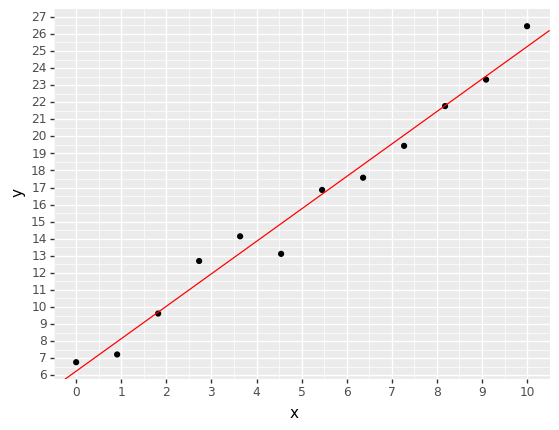

<ggplot: (8745686189853)>

In [189]:
(
    ggplot(data, aes(x="x", y="y"))
    + geom_point()
    + geom_abline(intercept=fit.params.Intercept, slope=fit.params.x, color="red")
    + scale_x_continuous(breaks=range(11))
    + scale_y_continuous(breaks=range(31))
)

In [190]:
data = data.append({'x':10, 'y': -60}, ignore_index=True)
data.tail()

,x,y
8,7.272727,19.442236
9,8.181818,21.774235
10,9.090909,23.325862
11,10.000000,26.454274
12,10.000000,-60.000000


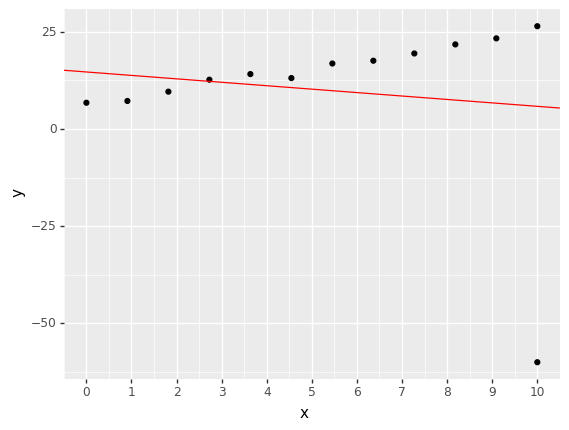

<ggplot: (8745686635086)>

In [192]:
fit = smf.ols("y ~ x", data).fit()
(
    ggplot(data, aes(x="x", y="y"))
    + geom_point()
    + geom_abline(intercept=fit.params.Intercept, slope=fit.params.x, color="red")
    + scale_x_continuous(breaks=range(11))
)

![](figures/always_plot_data.png)

# Understanding linear regression
Let's first focus on the table in the middle.

In [194]:
intercept = 5
slope = 2
data, x = generate_data(intercept, slope)
data.head()
fit = smf.ols("y ~ x", data).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     3208.
Date:                Mon, 29 Jun 2020   Prob (F-statistic):           1.09e-76
Time:                        12:16:26   Log-Likelihood:                -142.31
No. Observations:                 100   AIC:                             288.6
Df Residuals:                      98   BIC:                             293.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2085      0.201     25.867      0.000       4.809       5.608
x              1.9703      0.035     56.636      0.000       1.901       2.039
==============================================================================
Omnibus:                        0.397   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.556
Skew:                          -0.036   Prob(JB):                        0.757
Kurtosis:                       2.642   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

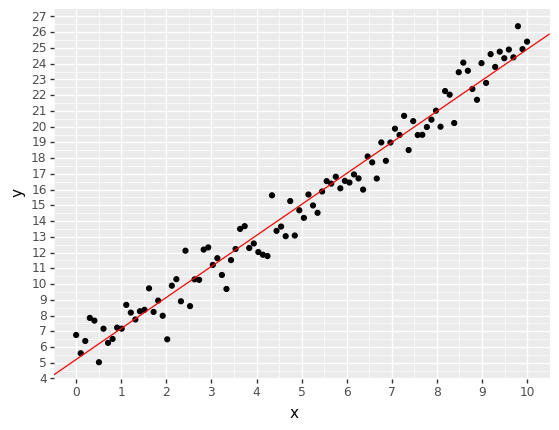

<ggplot: (8745686045455)>

In [196]:
(
    ggplot(data, aes(x="x", y="y"))
    + geom_point()
    + geom_abline(intercept=fit.params.Intercept, slope=fit.params.x, color="red")
    + scale_x_continuous(breaks=range(11))
    + scale_y_continuous(breaks=range(31))
)

## Effect size
While scientific literature often revoles around significance tests, Allen Downey argues that the most important parameter is the effect size. That is, how strong does a factor influence the result. In our table the effect size is named `coef`. So we can see that a change in $x$ of step 1 leads to a change of $y$ of $\approx$2. Whether you interpret an effect size as sufficiently large to be reported depends on the units and the problem.

In [195]:
fit.params

Intercept    5.208471
x            1.970267
dtype: float64

## Explained variance
The explained variance $R^2$ can be seen as a standardized effect size. It describes how much variance got explained by the model.

$$R^2 = 1 - \frac{\mathrm{var}(\mathrm{residuals})}{\mathrm{var}(y)} $$

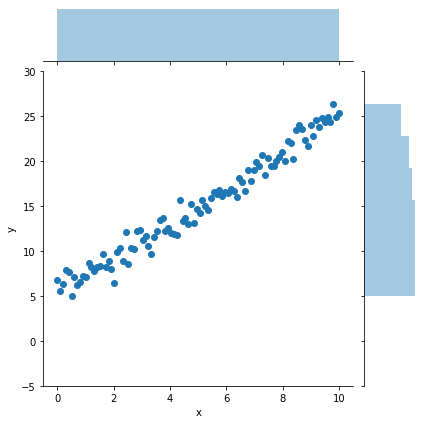

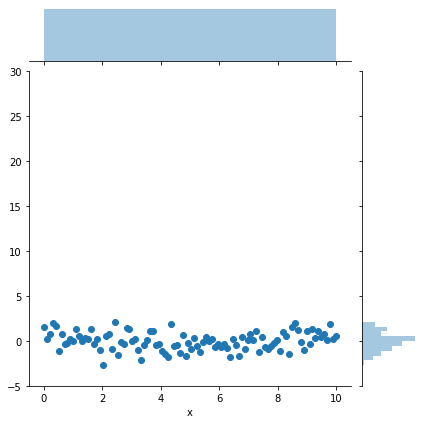

In [197]:
sns.jointplot(data.x, data.y, ylim=[-5, 30])

sns.jointplot(data.x, fit.resid, ylim=[-5, 30])

In [198]:
resid = fit.predict(data["x"]) - data["y"]
1 - (resid.var() / data.y.var())

0.9703537814132045

In [199]:
fit.rsquared

0.9703537814132045

Next we will look at *standard error* and *confidence intervals*. These measures describe our uncertainty towards the *effect size* that is due to sampling error. While these measures are often derived in an analytic way, we will use a computational method to calculate and understand them. To do this we first need to introduce the *sampling distribution*. 

## The sampling distribution

The sampling distribution is the distribution of a statistic based on various samples of the same distribution. The sampling distribution is subject to the famous *central limit theorem*, which states that the sampling distibution will converge to a normal distribution given enough samples. A good example of a sampling distribution is the mean computed on samples from a normal distribution.



![](figures/central_limit_theorem.png)

To draw random values from a normal distribution, we first instantiate the distribution and then call the `rvs` method on the
distribution object.

In [202]:
distribution = stats.norm()
distribution.rvs(5)

array([ 1.8831507 , -1.34775906, -1.270485  ,  0.96939671, -1.17312341])

Then we repeated sample from the same normal distribution, saving only the means of the drawn samples. This yields the *sampling distribution*.

In [203]:
distribution = stats.norm(loc=10, scale=2)
n_samples = 1000
sample_size = 20
sampling_distribution_of_means = []
for _ in range(n_samples):
    mean = distribution.rvs(sample_size).mean()
    sampling_distribution_of_means.append(mean)

In fact, the sampling distribution looks quite normal.

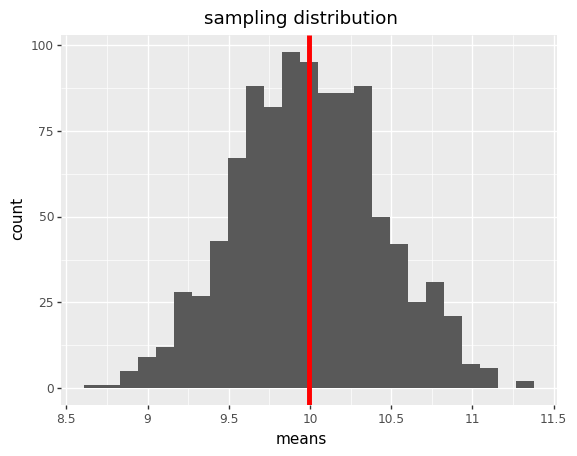

<ggplot: (-9223363291168941375)>

In [204]:
(
    qplot(sampling_distribution_of_means, bins=25)
    + geom_vline(
        aes(xintercept=np.mean(sampling_distribution_of_means)), color="red", size=2
    )
    + labs(x="means", title="sampling distribution")
)

Based on such a sampling distribution we can easily calculate the standard error and the confidence intervals.

### Standard error
The *standard error* is in fact just the *standard deviation* of the sampling distribution. It describes how much we expect to be off on average when we redo our experiment. Therefore it only tells us something about the variability of our experimental procedure due to sampling. It makes no statement about the *true parameter*.

In [205]:
stderr = np.std(sampling_distribution_of_means)
stderr

0.44677816930697395

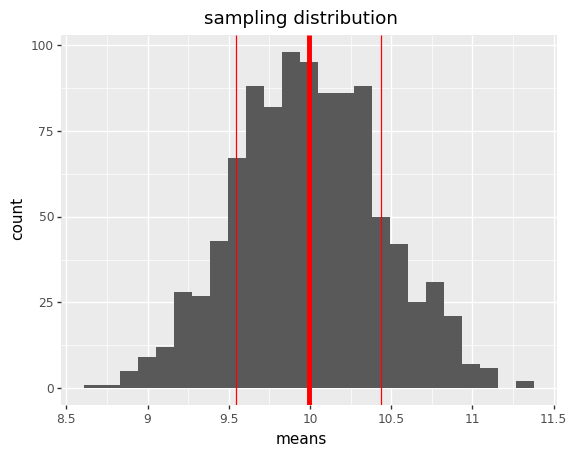

<ggplot: (8745724357580)>

In [206]:
(qplot(sampling_distribution_of_means, bins=25)
 + geom_vline(
    aes(xintercept=np.mean(sampling_distribution_of_means)), color="red", size=2
 )
 + geom_vline(
    aes(xintercept=np.mean(sampling_distribution_of_means) + stderr), color="red"
 )
 + geom_vline(
    aes(xintercept=np.mean(sampling_distribution_of_means) - stderr), color="red"
 )
 + labs(x="means", title="sampling distribution")
)

## Confidence intervals
Confidence intervals are a complementary way to quantify uncertainty due to sampling error. For example, a 95%-confidence interval tells us that if we repeat the experiment, our computed parameter will fall into the confidence interval in 95% of the cases. Confidence intervals can easily be computed by taking the left and the right percentile of the sampling distribution of the appropriate sizes.

In [208]:
def confidence_interval(sampling_distribution, size=95):
    sampling_distribution = np.asarray(sampling_distribution)
    left = (100 - size) / 2
    right = size + left
    return np.percentile(sampling_distribution, [left, right])


confidence_interval(sampling_distribution_of_means)

array([ 9.15129865, 10.89389599])

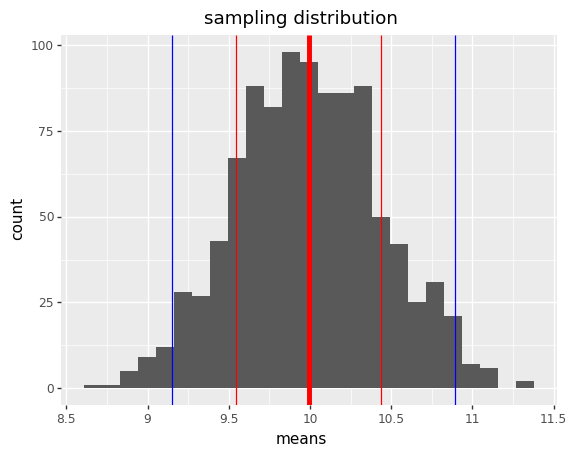

<ggplot: (-9223363291168922806)>

In [209]:
(
    qplot(sampling_distribution_of_means, bins=25)
    + geom_vline(
        aes(xintercept=np.mean(sampling_distribution_of_means)), color="red", size=2
    )
    + geom_vline(
        aes(xintercept=np.mean(sampling_distribution_of_means) + stderr), color="red"
    )
    + geom_vline(
        aes(xintercept=np.mean(sampling_distribution_of_means) - stderr), color="red"
    )
    + geom_vline(
        aes(xintercept=confidence_interval(sampling_distribution_of_means)),
        color="blue",
    )
    + labs(x="means", title="sampling distribution")
)

## Exercise
Calculate the standard error and the confidence intervals for the mean of the normal distribution $\mathcal{N}(10, 1)$. How
does the smaller variance of the underlying distribution influence the measures of sampling error?

In [ ]:
#for the solution, see "lecture_solutions.txt"

## Bootstrapping
Drawing samples from an analytic distribution is of course not an option for real experiments. In reality we are most of the time limited to a single sample from the population. A technique called bootstrapping still allows us to build a model of the population from a single sample. We can simply generate new samples by drawing from our real sample with replacement.

![](figures/bootstrap.png)

We will now bootstrap new samples and fit a new linear regression each time to get a sampling distribution for the slopes of our fit.

In [212]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     3208.
Date:                Mon, 29 Jun 2020   Prob (F-statistic):           1.09e-76
Time:                        13:14:59   Log-Likelihood:                -142.31
No. Observations:                 100   AIC:                             288.6
Df Residuals:                      98   BIC:                             293.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2085      0.201     25.867      0.000       4.809       5.608
x              1.9703      0.035     56.636      0.000       1.901       2.039
==============================================================================
Omnibus:                        0.397   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.556
Skew:                          -0.036   Prob(JB):                        0.757
Kurtosis:                       2.642   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [214]:
def get_sampling_distribution(formula, param, data, n_samples=1000):
    samples = np.zeros(n_samples)
    for i in range(n_samples):
        resampled = data.sample(len(data), replace=True)
        fit = smf.ols(formula, resampled).fit()
        samples[i] = fit.params[param]
    return samples


sampling_distribution_of_slopes = get_sampling_distribution("y ~ x", "x", data)

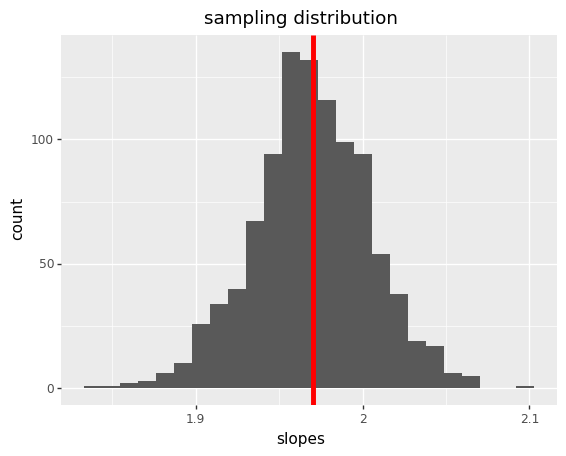

<ggplot: (8745685855040)>

In [215]:
(
    qplot(sampling_distribution_of_slopes, bins=25)
    + geom_vline(aes(xintercept=fit.params["x"]), color="red", size=2)
    + labs(x="slopes", title="sampling distribution")
)

In [216]:
sampling_distribution_of_slopes.std()

0.035377000343034065

In [217]:
confidence_interval(sampling_distribution_of_slopes, 95)

array([1.89896835, 2.03958262])

## Exercise 
Recalculate the standard error and the 95%-confidence intervals of the slope of `tip ~ total_bill` using bootstrapping.

In [39]:
fit_tips.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     203.4
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           6.69e-34
Time:                        23:16:30   Log-Likelihood:                -350.54
No. Observations:                 244   AIC:                             705.1
Df Residuals:                     242   BIC:                             712.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9203      0.160      5.761      0.000       0.606       1.235
total_bill     0.1050      0.007     14.260      0.000       0.091       0.120
==============================================================================
Omnibus:                       20.185   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.750
Skew:                           0.443   Prob(JB):                     6.35e-09
Kurtosis:                       4.711   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#for the solution, see "lecture_solutions.txt"

## Null Hypothesis Significance Testing

![](figures/nhst_image.png)

Null hypothesis testing is often emphasized in scientific literature. The interpretation of p-values and testing is not easy, but also made overly complicated. We will adopt Allen Downey's view and say

> A p-value tells us how likely it is that a result occured only by chance.

This *chance* again just corrects for the sampling error and not for other sources of error. 
There seems to be a lot of different tests:

* t-test
* F-test
* $\chi^2$ test
* Kruskall-Wallis test
* Mann-Whitney test
* ...

However, we will again introduce a computational way of doing tests that puts all statistical tests in a common framework.

![](figures/nht.png)

Source http://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html

The method works the following: 
1. We construct a computational model of our null hypothesis ($H_0$).
1. We sample from that model sufficiently many samples.
1. We calculate the statistic of interest from those samples.
1. We calculate the percantage of the statistic being equal or stronger than the statistic calculated from our experimental data. That is our p-value. 


Here we will look at the p-value of the slope of our fit. A null hypothesis would be that there is no relation between $x$ and $y$ and that the slope therefore should be zero. So a model of the $H_0$ distribution is to randomly shuffle the $y$ data and then compute a fit on the data. If $H_0$ is true, this should make no difference for the resulting slopes.

In [219]:
def get_null_hypothesis_distribution(formula, endog, param, data, n_iter=250):
    samples = np.zeros(n_iter)
    shuffled = data[[endog, param]].copy()

    for i in range(n_iter):
        np.random.shuffle(shuffled[endog])
        fit = smf.ols(formula, shuffled).fit()
        samples[i] = fit.params[param]

    return samples


null_hypothesis_distribution_of_slopes = get_null_hypothesis_distribution(
    "y ~ x", "y", "x", data
)

As `statsmodels` does a *two-sided* test, we need to check whether the absolute value of our slopes on the simulated data is bigger than the slope of our observed data.

In [221]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     3208.
Date:                Mon, 29 Jun 2020   Prob (F-statistic):           1.09e-76
Time:                        13:29:58   Log-Likelihood:                -142.31
No. Observations:                 100   AIC:                             288.6
Df Residuals:                      98   BIC:                             293.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2085      0.201     25.867      0.000       4.809       5.608
x              1.9703      0.035     56.636      0.000       1.901       2.039
==============================================================================
Omnibus:                        0.397   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.556
Skew:                          -0.036   Prob(JB):                        0.757
Kurtosis:                       2.642   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

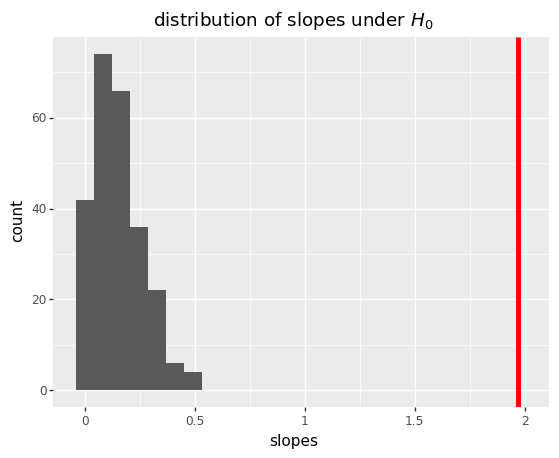

<ggplot: (-9223363291131525418)>

In [220]:
(qplot(np.abs(null_hypothesis_distribution_of_slopes), bins=25)
 + geom_vline(aes(xintercept=fit.params["x"]), color="red", size=2)
 + labs(x="slopes", title=r"distribution of slopes under $H_0$")
)

Our resulting p-value is

In [222]:
np.mean(np.abs(null_hypothesis_distribution_of_slopes) >= fit.params["x"])

0.0

As we constructed our data with such a strong relationship, this is not a really convincing way to show that we are computing p-values the right way. Let's construct some not so linear data, to check if our way of calculing p-values matches up with the `statsmodels` results.

In [248]:
def generate_data(intercept=1, slope=1, n_samples=100, scale=1):
    np.random.seed(3)
    x = np.linspace(0, 10, n_samples)
    noise = np.random.normal(scale=scale, size=n_samples)
    y = intercept + x * slope + noise
    data = pd.DataFrame({"x": x, "y": y})
    return data, x

In [249]:
not_so_linear_data, x = generate_data(intercept=5, slope=0.2, n_samples=100, scale=5)
not_so_linear_data.head()

,x,y
0,0.00000,13.943142
1,0.10101,7.202751
2,0.20202,5.522891
3,0.30303,-4.256857
4,0.40404,3.693867


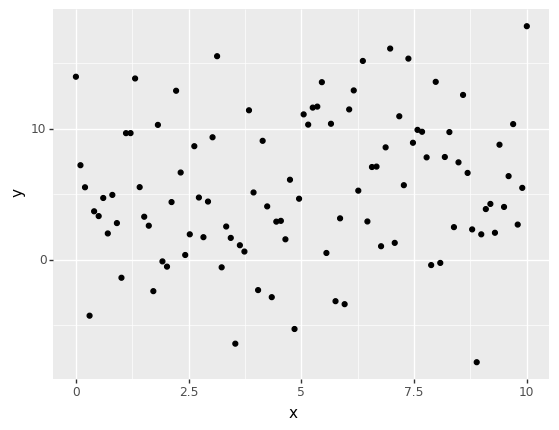

<ggplot: (8745685933460)>

In [250]:
(ggplot(not_so_linear_data, aes(x="x", y="y")) + geom_point())

In [251]:
not_so_linear_fit = smf.ols("y ~ x", not_so_linear_data).fit()
not_so_linear_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.210
Date:                Mon, 29 Jun 2020   Prob (F-statistic):              0.140
Time:                        13:38:24   Log-Likelihood:                -308.96
No. Observations:                 100   AIC:                             621.9
Df Residuals:                      98   BIC:                             627.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0879      1.066      3.835      0.000       1.973       6.203
x              0.2738      0.184      1.487      0.140      -0.092       0.639
==============================================================================
Omnibus:                        0.470   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.791   Jarque-Bera (JB):                0.609
Skew:                          -0.013   Prob(JB):                        0.737
Kurtosis:                       2.619   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [252]:
null_hypothesis_distribution_of_not_so_linear_slopes = get_null_hypothesis_distribution(
    "y ~ x", "y", "x", not_so_linear_data, n_iter=1000
)

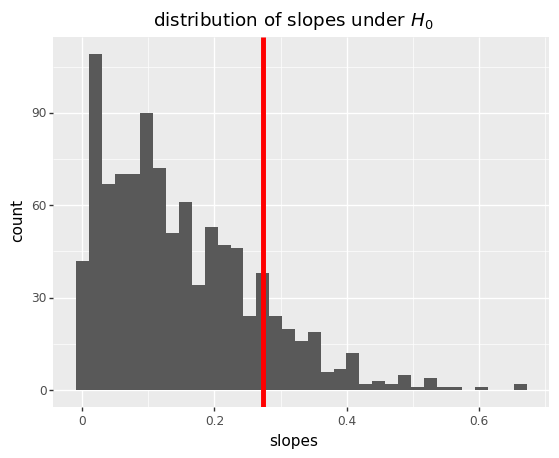

<ggplot: (8745723246102)>

In [253]:
(qplot(np.abs(null_hypothesis_distribution_of_not_so_linear_slopes), bins=35)
 + geom_vline(aes(xintercept=not_so_linear_fit.params["x"]), color="red", size=2)
 + labs(x="slopes", title=r"distribution of slopes under $H_0$")
)

In [254]:
np.mean(
    np.abs(null_hypothesis_distribution_of_not_so_linear_slopes)
    >= not_so_linear_fit.params["x"]
)

0.141

## Exercise
Recompute the p-value of `tip ~ total_bill` using bootstrapping?

In [51]:
fit_tips.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     203.4
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           6.69e-34
Time:                        23:17:01   Log-Likelihood:                -350.54
No. Observations:                 244   AIC:                             705.1
Df Residuals:                     242   BIC:                             712.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9203      0.160      5.761      0.000       0.606       1.235
total_bill     0.1050      0.007     14.260      0.000       0.091       0.120
==============================================================================
Omnibus:                       20.185   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.750
Skew:                           0.443   Prob(JB):                     6.35e-09
Kurtosis:                       4.711   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [3]:
#for the solution, see "lecture_solutions.txt"

# Assumptions
When we do linear regression, we make a set of assumptions that should be satisfied for the regression results to be valid. They can be convenient remembered with the word **LINE**.

1. Linearity of response
1. Independence of residuals
1. Normality of residuals 
1. Equal variance

All these assumption naturally follow from the structure of the linear model

\begin{equation}
\mathbf{y} = \mathbf{X}\mathbf{\beta} + \mathbf{\epsilon}
\end{equation}

\begin{equation}
\epsilon \sim \mathcal{N}(0, \sigma^2)
\end{equation}

which implies that after removing the data explained by the linear model, only white noise should be left.

We look at bunch of visual checks to verify these assumptions.

## Linearity of response
A plot that helps to check for many assumtions is the residual plot. We simply plot the residuals against the predictor variable and draw a horizontal line at zero to indicate our expected mean.

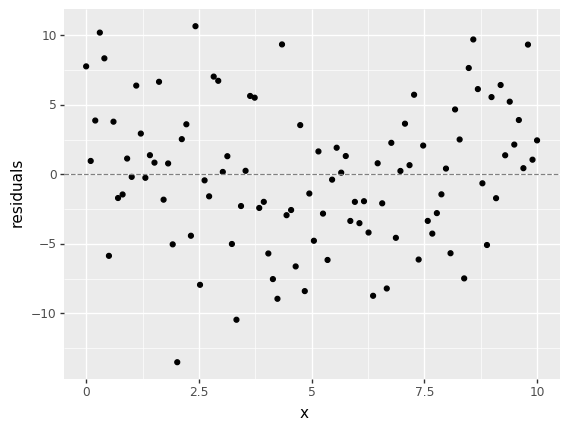

<ggplot: (8745724355532)>

In [256]:
data["residuals"] = fit.resid
(
    ggplot(data, aes(x="x", y="residuals"))
    + geom_point()
    + geom_hline(aes(yintercept=0), linetype="--", color="gray")
)

The residual plot of our data indicates a linear response. A residual plot of a non-linear response would look more like the following.

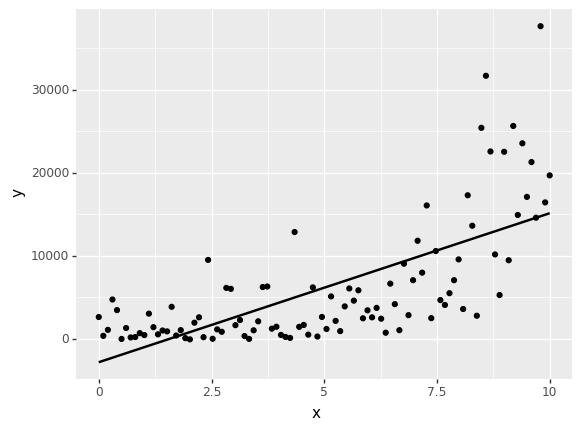

<ggplot: (8745686746565)>

In [257]:
data_cubed = data.copy()
data_cubed["y"] = data_cubed["y"] ** 3
(
    ggplot(data_cubed, aes(x="x", y="y"))
    + geom_point()
    + geom_smooth(method="lm", se=False)
)

In [259]:
fit_cubed = smf.ols("y ~ x", data_cubed).fit()
fit_cubed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     87.34
Date:                Mon, 29 Jun 2020   Prob (F-statistic):           3.18e-15
Time:                        13:46:02   Log-Likelihood:                -1004.0
No. Observations:                 100   AIC:                             2012.
Df Residuals:                      98   BIC:                             2017.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2804.7816   1111.891     -2.523      0.013   -5011.293    -598.270
x           1795.3444    192.101      9.346      0.000    1414.127    2176.562
==============================================================================
Omnibus:                       31.307   Durbin-Watson:                   1.476
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.811
Skew:                           1.268   Prob(JB):                     1.70e-13
Kurtosis:                       5.772   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

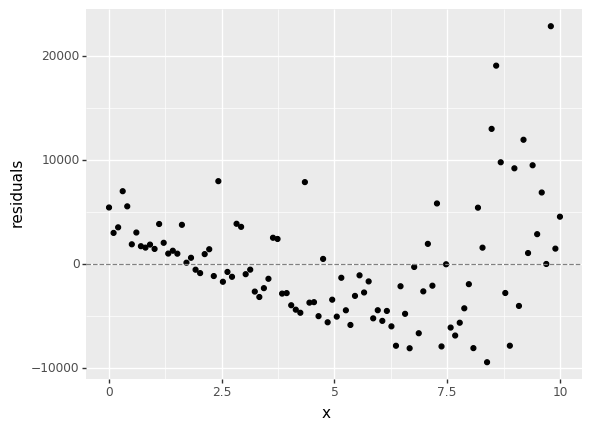

<ggplot: (-9223363291167772486)>

In [260]:
data_cubed["residuals"] = fit_cubed.resid
(
    ggplot(data_cubed, aes("x", "residuals"))
    + geom_point()
    + geom_hline(aes(yintercept=0), linetype="--", color="gray")
)

## Independence of residuals
Means that there is no relation between the current and previous residuals. Again our data shows no sign of dependent residuals. Dependent residuals can be often found in time series data.

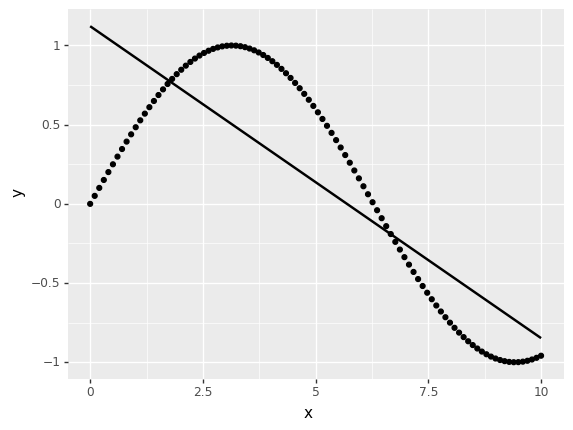

<ggplot: (8745687014769)>

In [261]:
data_sin = data.copy()
data_sin["y"] = np.sin(x * 0.5)
(
    ggplot(data_sin, aes(x="x", y="y"))
    + geom_point()
    + geom_smooth(method="lm", se=False)
)

In [262]:
fit_sin = smf.ols("y ~ x", data_sin).fit()
fit_sin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     181.6
Date:                Mon, 29 Jun 2020   Prob (F-statistic):           4.89e-24
Time:                        14:04:16   Log-Likelihood:                -55.590
No. Observations:                 100   AIC:                             115.2
Df Residuals:                      98   BIC:                             120.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1217      0.085     13.260      0.000       0.954       1.290
x             -0.1969      0.015    -13.475      0.000      -0.226      -0.168
==============================================================================
Omnibus:                        3.771   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                3.659
Skew:                          -0.417   Prob(JB):                        0.160
Kurtosis:                       2.571   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

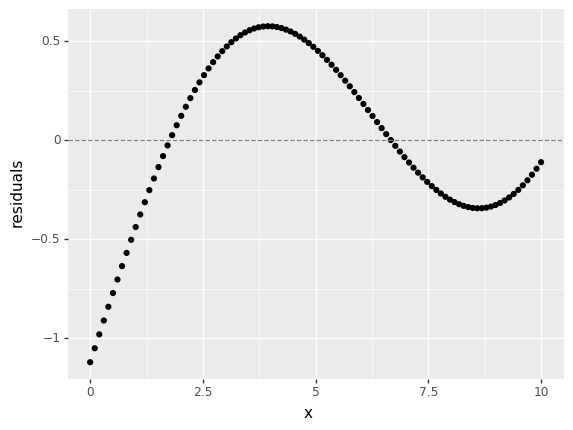

<ggplot: (-9223363291167905364)>

In [263]:
data_sin["residuals"] = fit_sin.resid
(
    ggplot(data_sin, aes("x", "residuals"))
    + geom_point()
    + geom_hline(aes(yintercept=0), linetype="--", color="gray")
)

## Normality of residuals
To check that our residuals actually follow a normal distribution, we can do two things. 

Firstly, we can make a histogram of the residuals and put the theoretical normal distribution on top. This way we can check if the two distributions approximately match up.

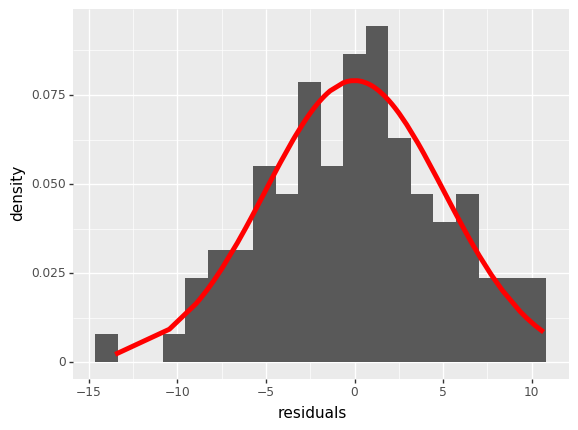

<ggplot: (8745689624566)>

In [264]:
(ggplot(data, aes(x="residuals"))
 + geom_histogram(aes(y="stat(density)"), bins=20)
 + geom_line(
     aes(y=stats.norm.pdf(data["residuals"], loc=0, scale=data["residuals"].std())),
     color="red",
     size=2,
 )
)

A more precise way of checking whether the empirical distribution of our residuals follows a normal distribution is a so called *qqplot*. A qqplot (quantile-quantile plot) plots the quantiles of the empirical distribution against the qunatiles of the theoretical distribution. The plot is contructed in a way that each original data point is shown and paired up with its theoretical quantile. If the two distributions match, the points should form a **straight line**. For more information about qqplot see https://seankross.com/2016/02/29/A-Q-Q-Plot-Dissection-Kit.html. 

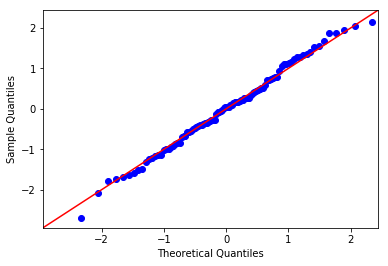

In [62]:
sm.qqplot(fit.resid, line="45", scale=np.std(fit.resid));

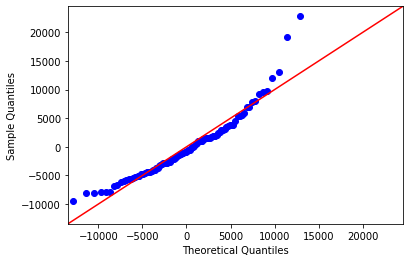

In [267]:
sm.qqplot(fit_cubed.resid, line="45", scale=np.std(fit_cubed.resid));

## Equal variance
Equal variance, also know by the fancy term homoscedasticity, can be evaluated based on the residualplot. Let's look at an example of unequal variance (heteroscedasticity), so you know what to look out for.

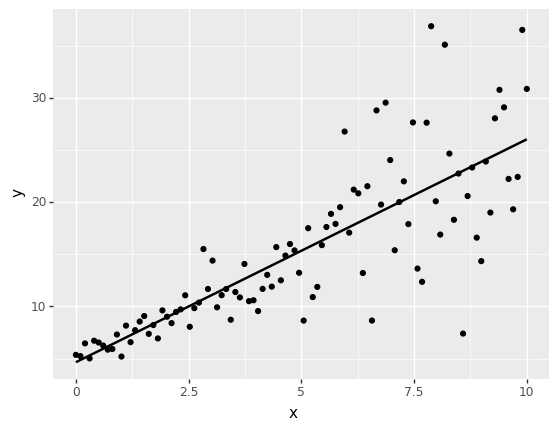

<ggplot: (8745688089555)>

In [269]:
slope = 2
x = np.linspace(0, 10, 100)
y = intercept + x * slope
y[:25] += np.random.normal(scale=1, size=25)
y[25:50] += np.random.normal(scale=2, size=25)
y[50:75] += np.random.normal(scale=4, size=25)
y[75:] += np.random.normal(scale=8, size=25)
data_var = pd.DataFrame({"x": x, "y": y})

(
    ggplot(data_var, aes(x="x", y="y"))
    + geom_point()
    + geom_smooth(method="lm", se=False)
)

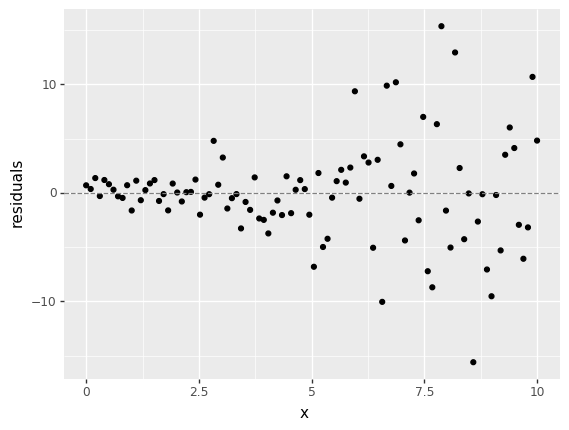

<ggplot: (8745687829645)>

In [270]:
fit_var = smf.ols("y ~ x", data_var).fit()
data_var["residuals"] = fit_var.resid
(
    ggplot(data_var, aes("x", "residuals"))
    + geom_point()
    + geom_hline(aes(yintercept=0), linetype="--", color="gray")
)

## Exercise
Check the assumptions of linear regression on the `tips` dataset. Was it right to use linear regression on the dataset?

In [ ]:
#for the solution, see "lecture_solutions.txt"

# Multiple linear regression

![](figures/two_predictors.png)

Often you will have more than a single predictor variable. Luckily, the framework of linear regression and `statsmodels`' formular API extend naturally to this scenario. Let's look at a real world weather dataset, to see if the amount of precipitation relates to other factors.

In [273]:
import vega_datasets

weather = vega_datasets.data.seattle_weather()
weather.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


/home/chris/anaconda3/envs/scientific_programming/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
/home/chris/anaconda3/envs/scientific_programming/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.


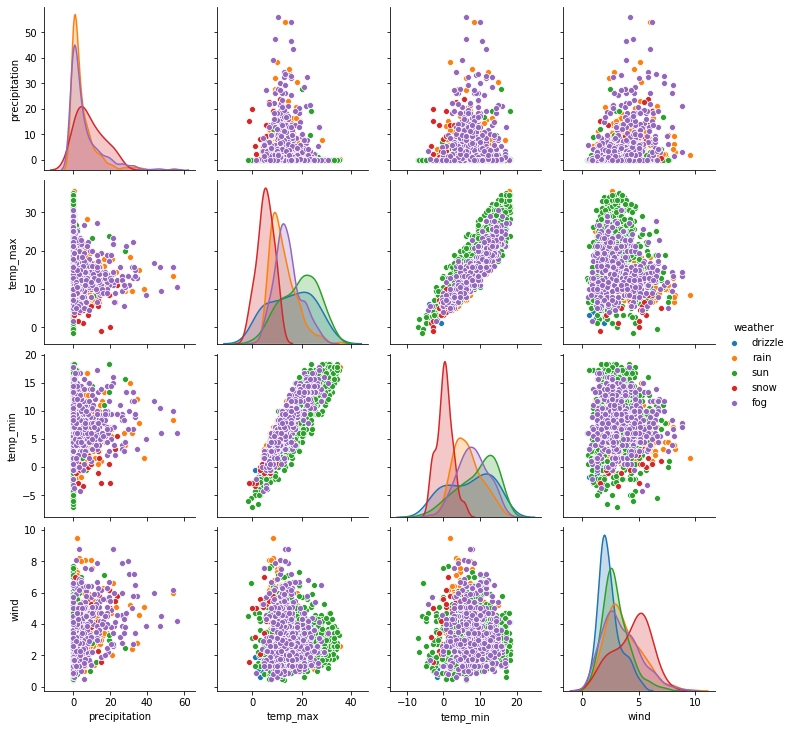

In [274]:
sns.pairplot(weather, hue="weather")

Adding additional predictor variables can be simply done with a $+$.

In [275]:
weather_fit = smf.ols("precipitation ~ temp_max + wind", weather).fit()
weather_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          precipitation   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     117.6
Date:                Mon, 29 Jun 2020   Prob (F-statistic):           4.49e-48
Time:                        14:16:08   Log-Likelihood:                -4738.0
No. Observations:                1461   AIC:                             9482.
Df Residuals:                    1458   BIC:                             9498.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2145      0.587      2.069      0.039       0.063       2.366
temp_max      -0.1630      0.022     -7.279      0.000      -0.207      -0.119
wind           1.3867      0.114     12.114      0.000       1.162       1.611
==============================================================================
Omnibus:                     1062.626   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17335.652
Skew:                           3.282   Prob(JB):                         0.00
Kurtosis:                      18.546   Cond. No.                         66.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

`plot_fit` is a `statsmodels` utility to compare the prediction of a model with the data.

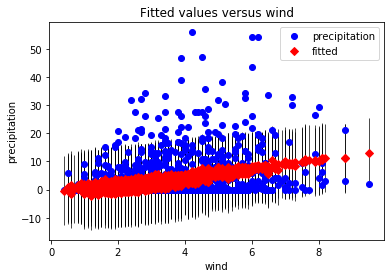

In [276]:
sm.graphics.plot_fit(weather_fit, "wind");

## Categorical data
Categorial data needs some transformation to be included in a linear regression. A common path is to use a *one-hot encoding*. For each category a new variable is added. If a datum belongs to the category that variable is 1, else it is 0. Thankfully, `patsy` does that automatically for us. 

In [277]:
y, X = patsy.dmatrices("precipitation ~ temp_max + wind + weather", weather)
X

DesignMatrix with shape (1461, 7)
  Columns:
    ['Intercept',
     'weather[T.fog]',
     'weather[T.rain]',
     'weather[T.snow]',
     'weather[T.sun]',
     'temp_max',
     'wind']
  Terms:
    'Intercept' (column 0)
    'weather' (columns 1:5)
    'temp_max' (column 5)
    'wind' (column 6)
  (to view full data, use np.asarray(this_obj))

In [278]:
cat_design_matrix = pd.DataFrame(X, columns=X.design_info.column_names)
cat_design_matrix.head()

,Intercept,weather[T.fog],weather[T.rain],weather[T.snow],weather[T.sun],temp_max,wind
0,1.0,0.0,0.0,0.0,0.0,12.8,4.7
1,1.0,0.0,1.0,0.0,0.0,10.6,4.5
2,1.0,0.0,1.0,0.0,0.0,11.7,2.3
3,1.0,0.0,1.0,0.0,0.0,12.2,4.7
4,1.0,0.0,1.0,0.0,0.0,8.9,6.1


In [279]:
weather.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In terms of a linear regression you can think of a parallel line with a different offset being added for each category.

In [280]:
weather_fit = smf.ols("precipitation ~ temp_max + wind + weather", weather).fit()
weather_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          precipitation   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     81.88
Date:                Mon, 29 Jun 2020   Prob (F-statistic):           2.12e-88
Time:                        14:21:17   Log-Likelihood:                -4634.6
No. Observations:                1461   AIC:                             9283.
Df Residuals:                    1454   BIC:                             9320.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.9678      0.916     -2.149      0.032      -3.764      -0.172
weather[T.fog]      5.1987      0.845      6.149      0.000       3.540       6.857
weather[T.rain]     3.4922      0.879      3.974      0.000       1.768       5.216
weather[T.snow]     6.2626      1.473      4.251      0.000       3.373       9.153
weather[T.sun]     -0.1660      0.823     -0.202      0.840      -1.781       1.449
temp_max           -0.0490      0.023     -2.143      0.032      -0.094      -0.004
wind                1.1426      0.109     10.485      0.000       0.929       1.356
==============================================================================
Omnibus:                     1071.264   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19880.637
Skew:                           3.264   Prob(JB):                         0.00
Kurtosis:                      19.851   Cond. No.                         232.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

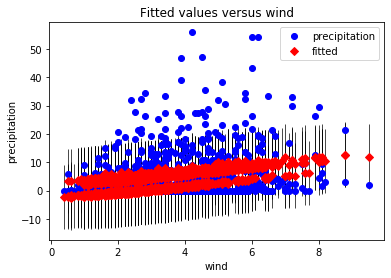

In [281]:
sm.graphics.plot_fit(weather_fit, "wind");

## Interactions
It can be the case that the slopes of continuous predictors vary based on a categorical variable. This can be expressed in a `patsy` formula with a `:`. The result is that a new variable gets added, which is the product of the interacting variables. Again, `patsy` does the work for us.

In [282]:
y, X = patsy.dmatrices(
    "precipitation ~ temp_max + wind + weather + wind:weather", weather
)
interaction_design_matrix = pd.DataFrame(X, columns=X.design_info.column_names)
interaction_design_matrix.head()

,Intercept,weather[T.fog],weather[T.rain],weather[T.snow],weather[T.sun],temp_max,wind,wind:weather[T.fog],wind:weather[T.rain],wind:weather[T.snow],wind:weather[T.sun]
0,1.0,0.0,0.0,0.0,0.0,12.8,4.7,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,10.6,4.5,0.0,4.5,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,11.7,2.3,0.0,2.3,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,12.2,4.7,0.0,4.7,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,8.9,6.1,0.0,6.1,0.0,0.0


$*$ is a shorthand for including variables and their interaction.

In [283]:
y, X = patsy.dmatrices("precipitation ~ temp_max + wind * weather", weather)
interaction_design_matrix = pd.DataFrame(X, columns=X.design_info.column_names)
interaction_design_matrix.head()

,Intercept,weather[T.fog],weather[T.rain],weather[T.snow],weather[T.sun],temp_max,wind,wind:weather[T.fog],wind:weather[T.rain],wind:weather[T.snow],wind:weather[T.sun]
0,1.0,0.0,0.0,0.0,0.0,12.8,4.7,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,10.6,4.5,0.0,4.5,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,11.7,2.3,0.0,2.3,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,12.2,4.7,0.0,4.7,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,8.9,6.1,0.0,6.1,0.0,0.0


In [284]:
weather_fit = smf.ols("precipitation ~ temp_max + wind * weather", weather).fit()
weather_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          precipitation   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     61.61
Date:                Mon, 29 Jun 2020   Prob (F-statistic):          3.04e-104
Time:                        14:23:43   Log-Likelihood:                -4588.6
No. Observations:                1461   AIC:                             9199.
Df Residuals:                    1450   BIC:                             9257.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3265      2.059      0.159      0.874      -3.713       4.366
weather[T.fog]          -1.4249      2.157     -0.661      0.509      -5.656       2.806
weather[T.rain]          2.4193      2.239      1.081      0.280      -1.973       6.811
weather[T.snow]          3.6898      4.200      0.878      0.380      -4.550      11.929
weather[T.sun]           0.7219      2.143      0.337      0.736      -3.481       4.925
temp_max                -0.0498      0.022     -2.232      0.026      -0.093      -0.006
wind                     0.1998      0.789      0.253      0.800      -1.347       1.747
wind:weather[T.fog]      2.2018      0.808      2.726      0.006       0.617       3.786
wind:weather[T.rain]     0.6128      0.821      0.747      0.455      -0.997       2.223
wind:weather[T.snow]     1.0071      1.116      0.903      0.367      -1.181       3.196
wind:weather[T.sun]     -0.1161      0.809     -0.144      0.886      -1.702       1.470
==============================================================================
Omnibus:                     1065.829   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21343.704
Skew:                           3.206   Prob(JB):                         0.00
Kurtosis:                      20.593   Cond. No.                         667.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

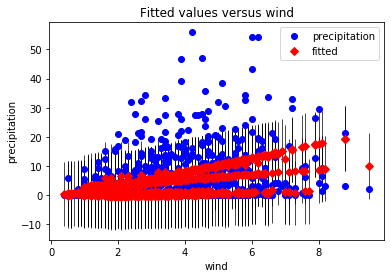

In [285]:
sm.graphics.plot_fit(weather_fit, "wind");

## Exercise
Ignoring for now that the tips dataset does not really satisfy the assumptions of linear regression, make a multiple regression to explain the amount of tip even better. In addition to `total_bill` use the variable `day`, `smoker`, `size` and the interaction between `smoker` and `size`. Does it make sense to include those additional predictors? 

In [288]:
fit_tips.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     203.4
Date:                Mon, 29 Jun 2020   Prob (F-statistic):           6.69e-34
Time:                        14:26:49   Log-Likelihood:                -350.54
No. Observations:                 244   AIC:                             705.1
Df Residuals:                     242   BIC:                             712.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9203      0.160      5.761      0.000       0.606       1.235
total_bill     0.1050      0.007     14.260      0.000       0.091       0.120
==============================================================================
Omnibus:                       20.185   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.750
Skew:                           0.443   Prob(JB):                     6.35e-09
Kurtosis:                       4.711   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#for the solution, see "lecture_solutions.txt"

**Obligatory relevant xkcd**

![](figures/linear_regression.png)

# Further topics
Unfortunately, we don't have time to look at all the statistic required to successfully analyze experiments in a single lecture. Other important topics include

* Generalized Linear Models
* Linear Mixed Effect Models
* Model comparision based on ANOVA
* Time series analysis
* Bayesian statistics!

Keep an eye open for courses from the NeuroBioPsychology!

# Further Readings

An computational approach to core statistical concepts, such as effect size, bootstrapping and hypothesis testing. There is also an accompanying book for free at https://greenteapress.com/wp/think-stats-2e/. Absolute recommendation! https://youtu.be/He9MCbs1wgE

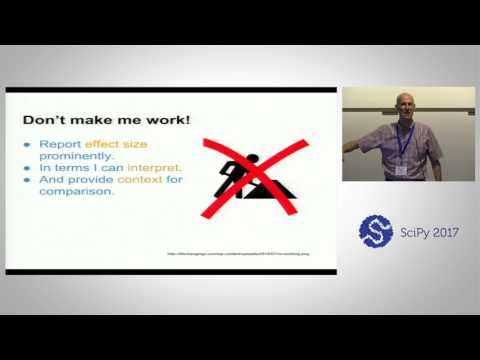

In [289]:
from IPython.display import YouTubeVideo

YouTubeVideo("He9MCbs1wgE")

An equally nice introduction to Bayesian statistics https://youtu.be/TpgiFIGXcT4. Again with a book for free at http://greenteapress.com/wp/think-bayes/.

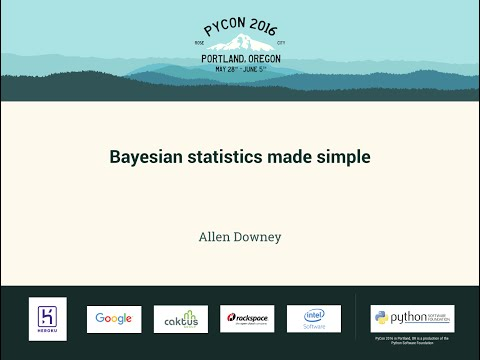

In [290]:
from IPython.display import YouTubeVideo

YouTubeVideo("TpgiFIGXcT4")

A tutorial on Bayesian statistics with `PyMC3`. https://youtu.be/TMmSESkhRtI

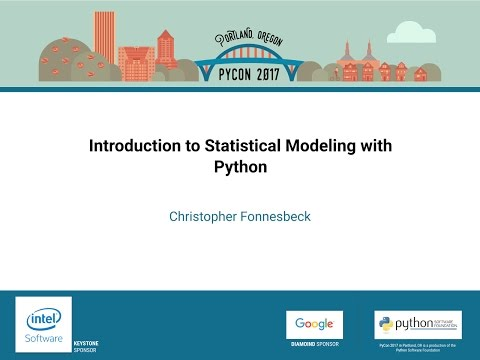

In [291]:
YouTubeVideo("TMmSESkhRtI")

Jake VanderPlas talking about other computational approaches to statisitics. https://youtu.be/Iq9DzN6mvYA

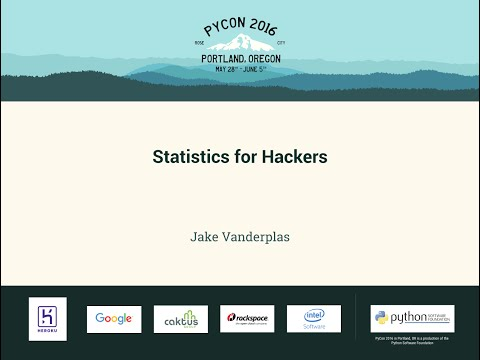

In [292]:
YouTubeVideo("Iq9DzN6mvYA")